In [1]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
sc.settings.verbosity = 3

from tqdm import tqdm

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
import scSpaMet as spamet

In [5]:
experiment = "Lung"
adata = sc.read_h5ad(data_dir / "adata" / f"{experiment}_vae.h5ad")

C:\Users\thu71\Anaconda3\envs\sgraph\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Unsupervised graph embedding

In [6]:
import stellargraph as sg
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from tensorflow import keras
import networkx as nx

def get_NN_radius(adata, r):
    data = adata.obsm["spatial"]
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=False)
    
    # Put in dataframe format
    neighbours = pd.DataFrame(m.tolist(), index = adata.obs.index)
    return neighbours

In [7]:
# Create nearest neighbor graph 
r = 15
graphs = []

for dataset in adata.obs.Dataset.unique():
    adata_subset = adata[adata.obs.Dataset == dataset, :] 
    neighbors = get_NN_radius(adata_subset, r)

    # Create edge features
    neighbors.index.set_names(['Cell'], inplace=True)
    neighbors.reset_index(inplace=True)
    neighbors = neighbors.melt(id_vars='Cell', value_name='Neighbor').dropna().astype(int) 
    
    # Create node features
    features = pd.DataFrame(adata_subset.obsm['Joint'])
    
    # Create graph
    graph = sg.StellarGraph(
        features, 
        edges=neighbors, source_column="Cell", target_column='Neighbor'
    )
    graphs.append(graph)

In [8]:
generator = sg.mapper.PaddedGraphGenerator(graphs)

gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

In [9]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

In [10]:
# Get traning examples
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))
targets = [graph_distance(graphs[left], graphs[right]) for left, right in  tqdm(graph_idx)]
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)


100%|███████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


In [11]:
# Training 
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

Epoch 1/100
10/10 [==============================] - 4s 292ms/step - loss: 6102.6479
Epoch 2/100
10/10 [==============================] - 3s 287ms/step - loss: 4414.6265
Epoch 3/100
10/10 [==============================] - 3s 288ms/step - loss: 3742.0632
Epoch 4/100
10/10 [==============================] - 3s 275ms/step - loss: 3396.2498
Epoch 5/100
10/10 [==============================] - 3s 259ms/step - loss: 3201.6819
Epoch 6/100
10/10 [==============================] - 3s 264ms/step - loss: 3134.1487
Epoch 7/100
10/10 [==============================] - 3s 264ms/step - loss: 3054.8694
Epoch 8/100
10/10 [==============================] - 3s 265ms/step - loss: 2956.2932
Epoch 9/100
10/10 [==============================] - 3s 267ms/step - loss: 2852.5950
Epoch 10/100
10/10 [==============================] - 3s 258ms/step - loss: 2757.8379
Epoch 11/100
10/10 [==============================] - 3s 256ms/step - loss: 2597.9570
Epoch 12/100
10/10 [==============================] - 3s 264ms/

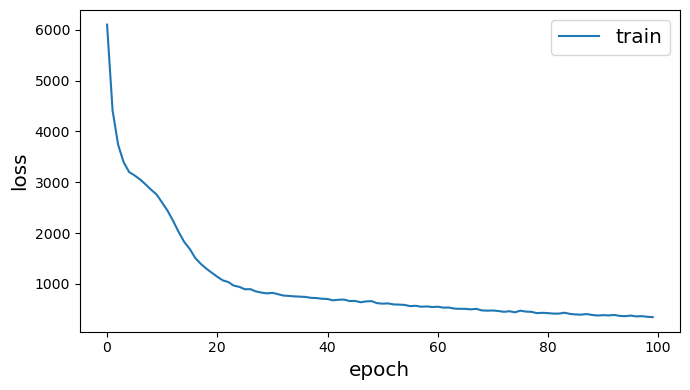

In [12]:
%%time
history = pair_model.fit(train_gen, epochs=100, verbose=1)
sg.utils.plot_history(history)

In [13]:
# Compute embedding of graphs 

embeddings = embedding_model.predict(generator.flow(graphs))

22/22 [==============================] - 0s 7ms/step


In [14]:
datasets = adata.obs.Dataset.unique().tolist()
adata_roi = sc.AnnData(embeddings)
adata_roi.obs['Dataset'] = datasets
adata_roi.obs['Core'] = [d[:2] for d in datasets]

In [15]:
sc.tl.tsne(adata_roi, perplexity=10.0)


computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=21
    finished (0:00:00)
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)


C:\Users\thu71\Anaconda3\envs\sgraph\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


C:\Users\thu71\Anaconda3\envs\sgraph\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


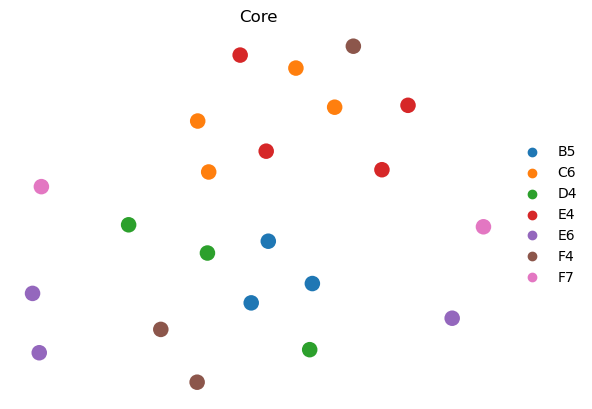

In [16]:
sc.pl.tsne(adata_roi, color='Core', frameon=False, size=500)